In [1]:
import pandas as pd

In [2]:
from GM.demo_script_Hermen import *

In [3]:
def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=0):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)
    
    # Correct the CL_baseline (find a better way to do it)
    
    results['CL_baseline'] = pd.Series(results['CL'].loc[:, 2018].values[0], index=results['CL'].index)
    
    
    corrected_results = BE2_models['BE2_partial_model'].run(results)
    #return results
    
    return corrected_results

In [38]:
ISO = 'FRA'
filtered_data_dict = {k: v.loc[ISO, 2018:] for k, v in data_dict.items() if k not in ['CL_corr_intercept', 'CL_corr_coef']}
filtered_data_dict['CL_corr_coef'] = 1.4

filtered_data_dict = run_BE2_projection(filtered_data_dict)
filtered_data_dict['R_rate'].loc[:, 2018] = 0

res = run_BE2_scenario(data_dict=filtered_data_dict, FDKGi_target=1.5, FLOi_target=1.5, CYi_target=1, R_rate=100)


In [39]:
res['BE2']

ISO  Year
FRA  2018    32.091088
     2019    32.051174
     2020    32.011260
     2021    31.971346
     2022    31.931432
     2023    31.891518
     2024    31.851604
     2025    31.811691
     2026    31.771777
     2027    31.731863
     2028    31.691949
     2029    31.652035
     2030    31.612121
     2031    31.572207
     2032    31.532293
     2033    31.492379
     2034    31.452465
     2035    31.412551
     2036    31.372637
     2037    31.332723
     2038    31.292809
     2039    31.252895
     2040    31.212981
     2041    31.173067
     2042    31.133153
     2043    31.093239
     2044    31.053325
     2045    31.013411
     2046    30.973497
     2047    30.933583
     2048    30.893670
     2049    30.853756
     2050    30.813842
dtype: float64

In [40]:
res['FL_RF']

ISO  Year
FRA  2018    17571.700000
     2019    17549.844833
     2020    17527.989667
     2021    17506.134500
     2022    17484.279333
     2023    17462.424167
     2024    17440.569000
     2025    17418.713833
     2026    17396.858666
     2027    17375.003500
     2028    17353.148333
     2029    17331.293166
     2030    17309.438000
     2031    17287.582833
     2032    17265.727666
     2033    17243.872500
     2034    17222.017333
     2035    17200.162166
     2036    17178.306999
     2037    17156.451833
     2038    17134.596666
     2039    17112.741499
     2040    17090.886333
     2041    17069.031166
     2042    17047.175999
     2043    17025.320833
     2044    17003.465666
     2045    16981.610499
     2046    16959.755332
     2047    16937.900166
     2048    16916.044999
     2049    16894.189832
     2050    16872.334666
dtype: float64

In [43]:
ISO = 'FRA'
filtered_data_dict = {k: v.loc[ISO, 2018:] for k, v in data_dict.items() if k not in ['CL_corr_intercept', 'CL_corr_coef']}

filtered_data_dict['CL_corr_coef'] = 1.4

filtered_data_dict = run_BE2_projection(filtered_data_dict)
#filtered_data_dict['R_rate'].loc[:, 2018] = 0

res = run_BE2_scenario(data_dict=filtered_data_dict, FDKGi_target=0.5, FLOi_target=0.5, CYi_target=1, R_rate=20)

res['BE2'].loc[:, 2018:]

ISO  Year
FRA  2018    31.381756
     2019    31.389738
     2020    31.397721
     2021    31.405704
     2022    31.413687
     2023    31.421670
     2024    31.429652
     2025    31.437635
     2026    31.445618
     2027    31.453601
     2028    31.461584
     2029    31.469566
     2030    31.477549
     2031    31.485532
     2032    31.493515
     2033    31.501498
     2034    31.509480
     2035    31.517463
     2036    31.525446
     2037    31.533429
     2038    31.541412
     2039    31.549394
     2040    31.557377
     2041    31.565360
     2042    31.573343
     2043    31.581325
     2044    31.589308
     2045    31.597291
     2046    31.605274
     2047    31.613257
     2048    31.621239
     2049    31.629222
     2050    31.637205
dtype: float64

In [46]:
res['R_rate']

ISO  Year
FRA  2018    20.0
     2019    20.0
     2020    20.0
     2021    20.0
     2022    20.0
     2023    20.0
     2024    20.0
     2025    20.0
     2026    20.0
     2027    20.0
     2028    20.0
     2029    20.0
     2030    20.0
     2031    20.0
     2032    20.0
     2033    20.0
     2034    20.0
     2035    20.0
     2036    20.0
     2037    20.0
     2038    20.0
     2039    20.0
     2040    20.0
     2041    20.0
     2042    20.0
     2043    20.0
     2044    20.0
     2045    20.0
     2046    20.0
     2047    20.0
     2048    20.0
     2049    20.0
     2050    20.0
dtype: float64

In [45]:
res['FL_RF']

ISO  Year
FRA  2018    17183.300000
     2019    17187.671033
     2020    17192.042067
     2021    17196.413100
     2022    17200.784133
     2023    17205.155167
     2024    17209.526200
     2025    17213.897233
     2026    17218.268267
     2027    17222.639300
     2028    17227.010333
     2029    17231.381367
     2030    17235.752400
     2031    17240.123433
     2032    17244.494467
     2033    17248.865500
     2034    17253.236533
     2035    17257.607567
     2036    17261.978600
     2037    17266.349633
     2038    17270.720667
     2039    17275.091700
     2040    17279.462733
     2041    17283.833767
     2042    17288.204800
     2043    17292.575833
     2044    17296.946867
     2045    17301.317900
     2046    17305.688934
     2047    17310.059967
     2048    17314.431000
     2049    17318.802034
     2050    17323.173067
dtype: float64

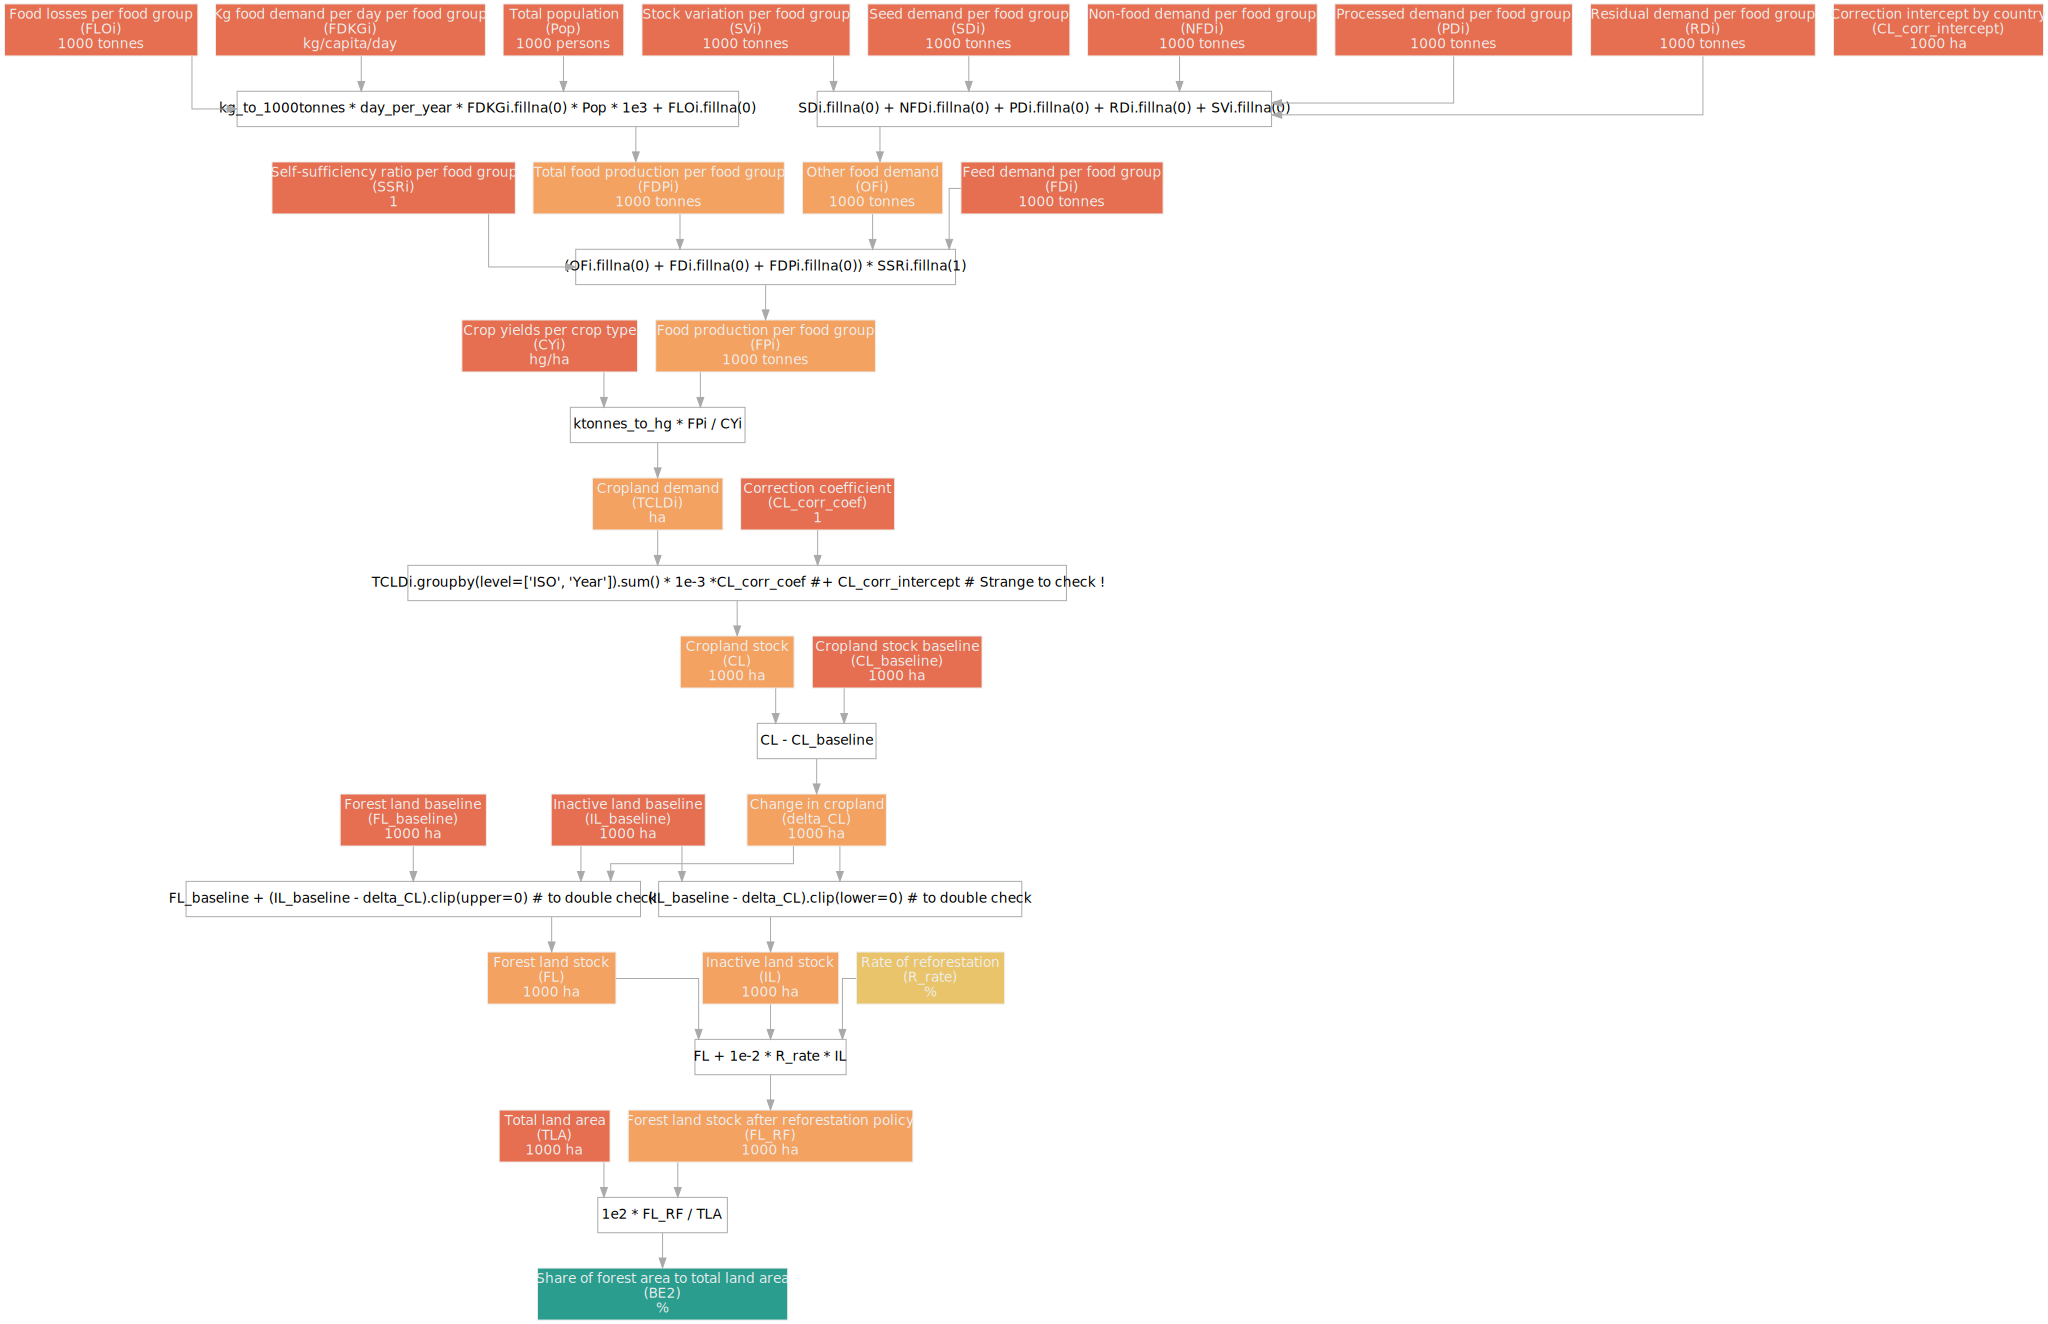

In [31]:
BE2_models['BE2_model'].draw()